# Xurich III — Electric Field Uniformity Study

This notebook analyzes COMSOL exports for the small-scale xenon TPC Xurich III.
The goal is to identify which gate/cathode pitch combinations provide the best
electric-field uniformity, especially at **low fields**, and to verify that the
simulated field magnitude matches theoretical expectations.

We will:
- Load wide-format and low-format COMSOL tables.
- Summarize metrics: ΔE (%), |Er/Ez|, mean Efield.
- Compare across pitches and voltages.
- Focus on **ΔE vs Efield**, **Efield error vs theory**, and **trade-offs**.

## Imports and configuration

In [13]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [14]:
# ----------------------------------------------------------------
#  Global style and legend configuration
# ----------------------------------------------------------------
FIGSIZE = (8.5, 6.0)
TITLE_SIZE = 22
LABEL_SIZE = 18
TICK_SIZE  = 16
LEGEND_SIZE = 12
LEGEND_TITLE_SIZE = 16
LINEWIDTH = 2.0
MARKERSIZE = 7

plt.rcParams.update({
    "figure.figsize": FIGSIZE,
    "axes.titlesize": TITLE_SIZE,
    "axes.labelsize": LABEL_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "legend.title_fontsize": LEGEND_TITLE_SIZE,
    "lines.linewidth": LINEWIDTH,
    "lines.markersize": MARKERSIZE,
    "axes.grid": True,

})

In [15]:
# ----------------------------------------------------------------
#  Helpers
# ----------------------------------------------------------------
def _geom_label(meta):
    """Return a short label for geometry (gate pitch / cathode pitch)."""
    return f"{meta['pitch_gate']} / {meta['pitch_cath']}"

def _dedup_legend(ax):
    h, l = ax.get_legend_handles_labels()
    uniq = dict(zip(l, h))
    ax.legend(uniq.values(), uniq.keys(), fontsize=9)

def _discover_vcaths():
    return sorted({
        float(v) for rec in raw_tables.values()
        for v in pd.unique(rec["df_long"]["V_cath"])
    })

def _series_label(meta):
    # Geometry only; never mention dataset, so low+standard look continuous
    return f"{meta['pitch_gate']} / {meta['pitch_cath']}"

### File Utilities

In [3]:
def read_header_lines(path: Path):
    hdr=[]
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if line.startswith("%"): hdr.append(line.rstrip("\n"))
            else: break
    return hdr

def extract_vcaths_from_header(header_lines):
    joined = " ".join(header_lines)
    seen, out = set(), []
    for m in re.finditer(r"V[_\s]*cath\s*=\s*([+-]?\d+)\s*V", joined, flags=re.IGNORECASE):
        v = int(m.group(1))
        if v not in seen: out.append(v); seen.add(v)
    return out  # may be []

def detect_dataset_tag(path: Path):
    return "low" if path.name.startswith("data_low_") else "standard"

def parse_pitches_from_filename(path: Path):
    toks = re.findall(r"(\d+(?:\.\d+)?mm)", path.name.lower())
    nice = []
    for t in toks:
        if t in {"27mm","2.7mm"}: nice.append("2.7 mm")
        elif t in {"05mm","0.5mm"}: nice.append("0.5 mm")
        elif t in {"1mm","1.0mm"}:  nice.append("1.0 mm")
        else:
            try: nice.append(f"{float(t[:-2]):.1f} mm")
            except: nice.append(t)
    if   len(nice)==0: return ("unknown","2.7 mm")
    elif len(nice)==1: return (nice[0], "2.7 mm")
    else:              return (nice[0], nice[1])

### Load Wide & Low Tables

In [4]:
def load_table_to_long(path: Path):
    base = pd.read_csv(path, sep=r"\s+", engine="python", header=None, comment="%")
    dataset = detect_dataset_tag(path)
    # LOW schema: exactly 5 numeric cols
    if base.shape[1] == 5:
        df = base.iloc[:, :5].copy()
        df.columns = ["V_cath","V_gate","Efield","ratio","deltaE"]
        for c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
        # Enforce: low files are ONLY the -1000 V cathode case
        df = df[df["V_cath"] == -1000]
        schema = "low"
        return df.assign(file=path.name, dataset=dataset, schema=schema)
    # WIDE schema: 1 + 3k cols
    ncols = base.shape[1]
    if ncols < 4 or (ncols - 1) % 3 != 0:
        raise ValueError(f"{path.name}: unexpected number of columns ({ncols}).")
    k = (ncols - 1)//3
    hdr = read_header_lines(path)
    vcaths = extract_vcaths_from_header(hdr)
    if not vcaths or len(vcaths) < k:  # minimal fallback if header oddities
        vcaths = vcaths[:k] + [f"V{j}" for j in range(k - len(vcaths))]

    base = base.iloc[:, : (1 + 3*k)]
    cols = ["V_gate"]
    for V in vcaths: cols += [f"Efield_{V}", f"ratio_{V}", f"deltaE_{V}"]
    base.columns = cols

    # build long
    parts=[]
    for V in vcaths:
        sub = base[["V_gate", f"Efield_{V}", f"ratio_{V}", f"deltaE_{V}"]].copy()
        sub.columns = ["V_gate","Efield","ratio","deltaE"]
        try:
            Vc = int(V)
        except Exception:
            Vc = V
        sub["V_cath"] = Vc
        parts.append(sub)
    df = pd.concat(parts, ignore_index=True)
    for c in ["V_gate","Efield","ratio","deltaE"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    schema = "wide"
    return df.assign(file=path.name, dataset=dataset, schema=schema)

# -------- discover + summarize in a few lines --------
def discover(globs=("data_*.txt","data_low_*.txt")):
    paths = sorted({p for g in globs for p in glob(g)})
    return [Path(p) for p in paths]

def load_all(globs=("data_*.txt","data_low_*.txt")):
    rows, raw = [], {}
    for p in discover(globs):
        df = load_table_to_long(p)
        gate, cath = parse_pitches_from_filename(p)
        schema = df["schema"].iat[0]
        meta = {
            "file": p.name,
            "dataset": df["dataset"].iat[0],
            "schema": schema,
            "pitch_gate": gate,
            "pitch_cath": cath,
        }
        # enforce low always = -1000
        if schema == "low":
            df.loc[:, "V_cath"] = -1000
        raw[p.name] = {"df_long": df, "meta": meta}

        d = df.copy()
        d["ratio_abs"] = d["ratio"].abs()
        for V in pd.unique(d["V_cath"]):
            sub = d[d["V_cath"] == V].dropna()
            if sub.empty: continue
            rows.append({
                **meta, "Vcath": V,
                "V_gate_min": sub["V_gate"].min(),
                "V_gate_max": sub["V_gate"].max(),
                "mean_deltaE(%)": sub["deltaE"].mean(),
                "p95_deltaE(%)": np.percentile(sub["deltaE"],95),
                "p95|Er/Ez|": np.percentile(sub["ratio_abs"],95),
                "mean_Efield(V/cm)": sub["Efield"].mean(),
                "min_Efield(V/cm)": sub["Efield"].min(),
                "max_Efield(V/cm)": sub["Efield"].max(),
            })
    summary = pd.DataFrame(rows)
    return raw, summary
    
raw_tables, summary_df = load_all()
print("Loaded:", list(raw_tables))

Loaded: ['data_2D_pitch_05mm.txt', 'data_2D_pitch_05mm_05mm_2D.txt', 'data_2D_pitch_1mm.txt', 'data_2D_pitch_1mm_1mm_2D.txt', 'data_2D_pitch_27mm.txt', 'data_low_pitch_05mm_05mm_2D.txt', 'data_low_pitch_1mm_1mm_2D.txt', 'data_low_pitch_27mm_27mm_2D.txt']


In [5]:
def keep_only_valid_for_vcath(df_or_summary: pd.DataFrame, target_vcath: int):
    d = df_or_summary
    # low appears only at -1000
    if target_vcath == -1000: 
        return d
    return d[d["dataset"] != "low"]
    
# Build an index of "low" rows keyed by geometry config so we can append them at V_cath = -1000
low_by_config = {}
for fname, rec in raw_tables.items():
    if rec.get("schema") == "low":
        meta = rec["meta"]
        cfg = f"{meta['pitch_gate']} / {meta['pitch_cath']}"
        df_low = rec["df_long"].copy()
        # ensure numeric and fix V_cath exactly at -1000
        for c in ("V_cath", "V_gate", "Efield", "ratio", "deltaE"):
            if c in df_low.columns:
                df_low[c] = pd.to_numeric(df_low[c], errors="coerce")
        df_low = df_low.dropna(subset=["V_cath","V_gate"])
        df_low.loc[:, "V_cath"] = -1000.0
        low_by_config.setdefault(cfg, []).append(df_low)

In [6]:
ENFORCE_VCATH_LT_VGATE = True  # apply your requested physics cut everywhere

def get_slice_for_vcath(rec, target_vcath):
    """
    From one raw_tables 'rec', return a clean DataFrame for this V_cath:
    - numeric coercion,
    - append 'low' rows (only if V_cath == -1000),
    - enforce V_cath < V_gate (if enabled),
    - drop duplicate V_gate to avoid double curves.
    """
    df = rec["df_long"].copy()
    meta = rec["meta"]
    # numeric coercion once
    for c in ("V_cath", "V_gate", "Efield", "ratio", "deltaE"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["V_cath","V_gate"])

    # select target V_cath (after coercion both sides are numeric)
    out = df[df["V_cath"] == float(target_vcath)].copy()

    # append LOW data only for -1000, same geometry config
    if float(target_vcath) == -1000.0:
        cfg = f"{meta['pitch_gate']} / {meta['pitch_cath']}"
        for extra in low_by_config.get(cfg, []):
            out = pd.concat([out, extra], ignore_index=True, copy=False)

    # requested physics cut: only keep rows where V_cath < V_gate
    if ENFORCE_VCATH_LT_VGATE:
        out = out[out["V_cath"] < out["V_gate"]]

    # sort and drop duplicate V_gate (prevents “two curves”)
    out = (out.sort_values("V_gate")
               .drop_duplicates(subset=["V_gate"], keep="last"))

    return out


### File and Summary results

In [7]:
# File patterns
GLOBS = ["data_*.txt", "data_low_*.txt"]

# Default cathode pitch if only one pitch token is present
DEFAULT_CATHODE_PITCH_LABEL = "2.7 mm"

# Map pitch tokens
PITCH_LABEL_MAP = {
    "27mm": "2.7 mm",
    "05mm": "0.5 mm",
    "1mm":  "1.0 mm",
    "2.7mm":"2.7 mm",
    "0.5mm":"0.5 mm",
    "1.0mm":"1.0 mm",
}

# Plot style
plt.rcParams.update({"figure.figsize": (7,5), "axes.grid": True})

### Comparative Plots

In [11]:
def _series_label(meta):
    # Show geometry only; never include "dataset" so low/standard look continuous
    return f"{meta['pitch_gate']} / {meta['pitch_cath']}"

# === 1) Per-file: ΔE vs V gate (fixed V_cath)
def plot_deltaE_vs_Vgate(file_name: str, Vcath):
    rec = raw_tables[file_name]
    meta = rec["meta"]
    sub = get_slice_for_vcath(rec, Vcath)
    if sub.empty:
        print(f"{file_name}: V cath = {Vcath} not present after filtering.")
        return
    x = sub["V_gate"].values
    y = sub["deltaE"].values
    plt.figure()
    plt.plot(x, y, marker="o", lw=1.2, alpha=0.95, label=_series_label(meta))
    plt.title(f"ΔE (%) vs V gate — V cath = {Vcath} V")
    plt.xlabel("V gate (V)")
    plt.ylabel("ΔE (%)")
    plt.legend()
    plt.tight_layout(); plt.show()

# === 2) Per-file: |Er/Ez| vs V gate (fixed V_cath)
def plot_ratio_vs_Vgate(file_name: str, Vcath):
    rec = raw_tables[file_name]
    meta = rec["meta"]
    sub = get_slice_for_vcath(rec, Vcath)
    if sub.empty:
        print(f"{file_name}: V cath = {Vcath} not present after filtering.")
        return
    x = sub["V_gate"].values
    y = sub["ratio"].abs().values
    plt.figure()
    plt.plot(x, y, marker="o", lw=1.2, alpha=0.95, label=_series_label(meta))
    plt.title(f"|Er/Ez| vs V gate — V cath = {Vcath} V")
    plt.xlabel("V gate (V)")
    plt.ylabel("|Er/Ez|")
    plt.legend()
    plt.tight_layout(); plt.show()

# === 3) Per-file: |E| vs V gate (fixed V_cath)
def plot_Efield_vs_Vgate(file_name: str, Vcath):
    rec = raw_tables[file_name]
    meta = rec["meta"]
    sub = get_slice_for_vcath(rec, Vcath)
    if sub.empty:
        print(f"{file_name}: V cath = {Vcath} not present after filtering.")
        return
    x = sub["V_gate"].values
    y = sub["Efield"].values
    plt.figure()
    plt.plot(x, y, marker="o", lw=1.2, alpha=0.95, label=_series_label(meta))
    plt.title(f"|E| (V/cm) vs V gate — V cath = {Vcath} V")
    plt.xlabel("V gate (V)")
    plt.ylabel("|E| (V/cm)")
    plt.legend()
    plt.tight_layout(); plt.show()

# === 4) Overlay: all geometries in one plot at fixed V_cath
def plot_overlay_vs_Vgate(Vcath, y="deltaE"):
    ylabel_map = {"deltaE": "ΔE (%)", "ratio": "|Er/Ez|", "Efield": "|E| (V/cm)"}
    if y not in ylabel_map:
        raise ValueError("y must be 'deltaE', 'ratio', or 'Efield'")

    plt.figure(figsize=(7,5))
    seen = set()
    for rec in raw_tables.values():
        meta = rec["meta"]
        key = (meta["pitch_gate"], meta["pitch_cath"])
        if key in seen:
            continue
        sub = get_slice_for_vcath(rec, Vcath)
        if sub.empty:
            continue
        x = sub["V_gate"].values
        if y == "deltaE":
            yy = sub["deltaE"].values
        elif y == "ratio":
            yy = sub["ratio"].abs().values
        else:
            yy = sub["Efield"].values
        plt.plot(x, yy, lw=1.3, alpha=0.95, label=_series_label(meta))
        seen.add(key)

    plt.title(f"{ylabel_map[y]} vs V gate — V cath = {Vcath} V")
    plt.xlabel("V gate (V)")
    plt.ylabel(ylabel_map[y])
    plt.legend()
    plt.grid(True); plt.tight_layout(); plt.show()

In [12]:
def _collect_metrics_from_raw(vcaths=None, percentile=95, emax=None, 
                              filter_gate=None, filter_cath=None, L_cm=None):
    """
    Build per-(geometry, V_cath) metrics from raw points (merged low+standard).
    """
    
    if vcaths is None:
        vcaths = _discover_vcaths()
    if L_cm is None:
        L_cm = float(DRIFT_LENGTH_CM)

    rows = []
    for rec in raw_tables.values():
        meta = rec["meta"]
        if filter_gate and meta["pitch_gate"] != filter_gate: 
            continue
        if filter_cath and meta["pitch_cath"] != filter_cath: 
            continue
        geom = _geom_label(meta)

        for Vc in vcaths:
            sub = get_slice_for_vcath(rec, Vc)
            if sub.empty:
                continue
            d = sub[["V_gate","Efield","deltaE","ratio"]].dropna().astype(float)
            if d.empty:
                continue

            # theoretical field and optional low-field cap
            E_th = np.abs(d["V_gate"].values - float(Vc)) / float(L_cm)
            if emax is not None:
                mask = E_th <= float(emax)
                if not np.any(mask):
                    continue
                d = d.iloc[mask.nonzero()[0]]
                E_th = E_th[mask]
            if len(d) == 0:
                continue

            rel = np.abs(d["Efield"].values - E_th) / np.where(E_th == 0, np.nan, E_th)

            rows.append({
                "geom": geom,
                "Vcath": int(Vc) if float(Vc).is_integer() else float(Vc),
                "mean_E(V/cm)": float(np.nanmean(d["Efield"].values)),
                f"p{percentile}_ΔE(%)": float(np.nanpercentile(d["deltaE"].values, percentile)),
                "p95_|Er/Ez|": float(np.nanpercentile(np.abs(d["ratio"].values), 95)),
                "median_rel_err": float(np.nanmedian(rel)),
            })
    return pd.DataFrame(rows)

# ---------- 1) Uniformity vs field ----------
def plot_uniformity_vs_field(vcath_list=None, percentile=95, emax=None, 
                             filter_gate=None, filter_cath=None):
    """
    Scatter: pXX(ΔE) vs mean |E|, one color per geometry.
    Uses raw points (merged low+standard at V_cath = -1000), and enforces V_cath < V_gate.
    """
    df = _collect_metrics_from_raw(vcaths=vcath_list, percentile=percentile, emax=emax,
                                   filter_gate=filter_gate, filter_cath=filter_cath)
    if df.empty:
        print("No data for uniformity vs field."); return

    plt.figure(figsize=(7,5))
    ax = plt.gca()
    for geom, sub in df.groupby("geom"):
        ax.scatter(sub["mean_E(V/cm)"].values, sub[f"p{percentile}_ΔE(%)"].values,
                   s=50, label=geom)
    ax.set_title(f"p{percentile}(ΔE) vs mean |E|")
    ax.set_xlabel("Mean |E| (V/cm)")
    ax.set_ylabel(f"p{percentile} ΔE (%)")
    _dedup_legend(ax)
    ax.grid(True); plt.tight_layout(); plt.show()

# ---------- 2) Field error vs theoretical (default: cathode = 2.7 mm) ----------
def plot_field_error(drift_length_cm=None, filter_cath="2.7 mm", vcath_list=None, emax=None):
    """
    Scatter: E_sim − E_theory vs E_theory, points from raw (merged low+standard).
    By default only cathode pitch = 2.7 mm (set filter_cath=None to include all).
    """
    if drift_length_cm is None:
        drift_length_cm = float(DRIFT_LENGTH_CM)
    if vcath_list is None:
        vcath_list = _discover_vcaths()

    plt.figure(figsize=(7,5))
    ax = plt.gca()
    plotted = False

    for rec in raw_tables.values():
        meta = rec["meta"]
        if filter_cath and meta["pitch_cath"] != filter_cath:
            continue

        for Vc in vcath_list:
            sub = get_slice_for_vcath(rec, Vc)
            if sub.empty:
                continue
            d = sub[["V_gate","Efield"]].dropna().astype(float)
            if d.empty:
                continue
            E_th = np.abs(d["V_gate"].values - float(Vc)) / float(drift_length_cm)
            E_err = d["Efield"].values - E_th
            if emax is not None:
                mask = E_th <= float(emax)
                E_th = E_th[mask]; E_err = E_err[mask]
            if E_th.size == 0:
                continue
            ax.scatter(E_th, E_err, s=30, label=_geom_label(meta))
            plotted = True

    if not plotted:
        plt.close(); print("No data for field error plot."); return

    ax.axhline(0, ls="--", lw=1)
    ax.set_title(f"Field bias: E_sim − E_theory vs E_theory"
                 + (f" — cathode = {filter_cath}" if filter_cath else ""))
    ax.set_xlabel("E_theory = |V gate − V cath| / L  (V/cm)")
    ax.set_ylabel("E_sim − E_theory (V/cm)")
    _dedup_legend(ax)
    ax.grid(True); plt.tight_layout(); plt.show()

# ---------- 3) Trade-off: uniformity vs relative field error ----------
def plot_tradeoff(drift_length_cm=None, percentile=95, vcath_list=None, emax=None,
                  filter_gate=None, filter_cath=None):
    """
    Scatter: (median relative field error) vs pXX(ΔE).
    Lower-left is better. Built from raw points (merged low+standard).
    """
    if drift_length_cm is None:
        drift_length_cm = float(DRIFT_LENGTH_CM)

    df = _collect_metrics_from_raw(vcaths=vcath_list, percentile=percentile, emax=emax,
                                   filter_gate=filter_gate, filter_cath=filter_cath,
                                   L_cm=drift_length_cm)
    if df.empty:
        print("No data for trade-off plot."); return

    plt.figure(figsize=(7,5))
    ax = plt.gca()
    for geom, sub in df.groupby("geom"):
        ax.scatter(sub["median_rel_err"].values, sub[f"p{percentile}_ΔE(%)"].values,
                   s=50, label=geom)
    ax.set_title(f"Trade-off: p{percentile}(ΔE) vs median relative E-field error")
    ax.set_xlabel("Median relative error |E_sim − E_theory| / E_theory")
    ax.set_ylabel(f"p{percentile} ΔE (%)")
    _dedup_legend(ax)
    ax.grid(True); plt.tight_layout(); plt.show()

# ---------- 4) Radiality vs field ----------
def plot_radiality_vs_field(vcath_list=None, emax=None, filter_gate=None, filter_cath=None):
    """
    Scatter: p95(|Er/Ez|) vs mean |E| per (geometry, V_cath).
    """
    df = _collect_metrics_from_raw(vcaths=vcath_list, percentile=95, emax=emax,
                                   filter_gate=filter_gate, filter_cath=filter_cath)
    if df.empty:
        print("No data for radiality vs field."); return

    plt.figure(figsize=(7,5))
    ax = plt.gca()
    for geom, sub in df.groupby("geom"):
        ax.scatter(sub["mean_E(V/cm)"].values, sub["p95_|Er/Ez|"].values,
                   s=50, label=geom)
    ax.set_title("|Er/Ez| (p95) vs mean |E|")
    ax.set_xlabel("Mean |E| (V/cm)")
    ax.set_ylabel("p95 |Er/Ez|")
    _dedup_legend(ax)
    ax.grid(True); plt.tight_layout(); plt.show()

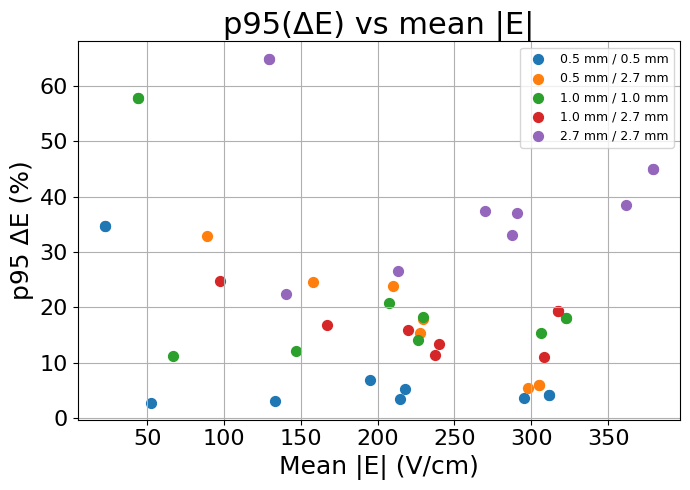

In [13]:
VC_LIST = [-1000, -500, -60, 0, 60, 500, 1000, -1000]

# Uniformity vs field (p95 by default); focus on low fields with emax if you want:
plot_uniformity_vs_field(vcath_list=VC_LIST, percentile=95, emax=600)

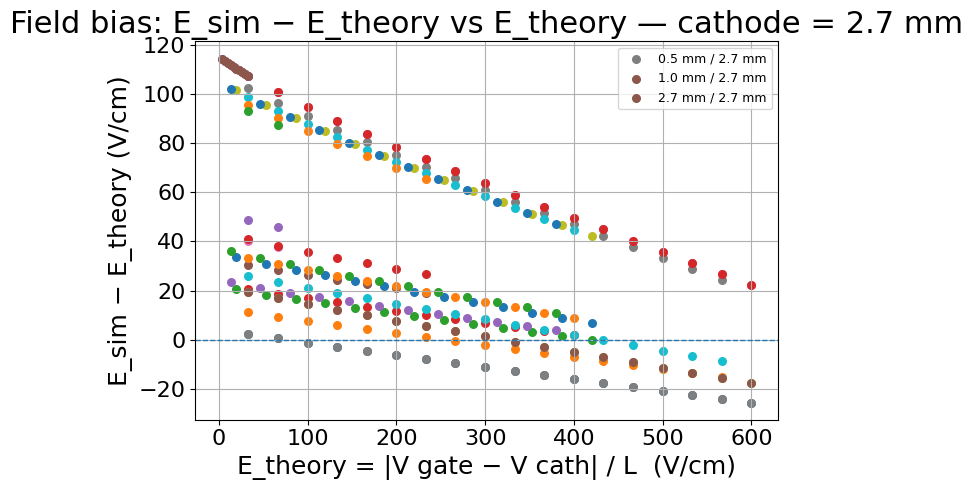

In [14]:
# Field bias (default restricts to cathode pitch = 2.7 mm):
plot_field_error(drift_length_cm=DRIFT_LENGTH_CM, filter_cath="2.7 mm", vcath_list=VC_LIST, emax=600)

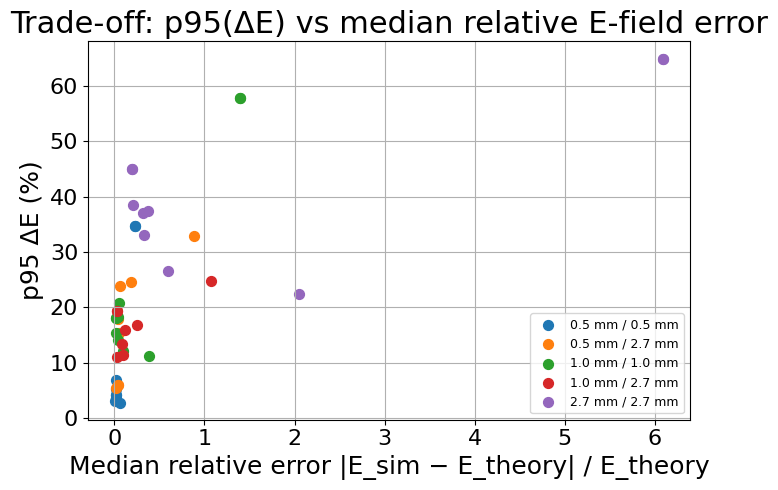

In [15]:
# Trade-off (lower-left is best):
plot_tradeoff(drift_length_cm=DRIFT_LENGTH_CM, percentile=95, vcath_list=VC_LIST, emax=600)

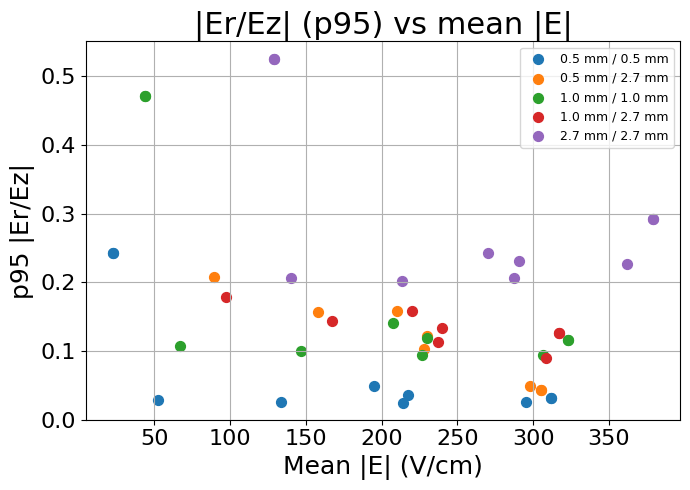

In [16]:
# Radiality vs field:
plot_radiality_vs_field(vcath_list=VC_LIST, emax=600)

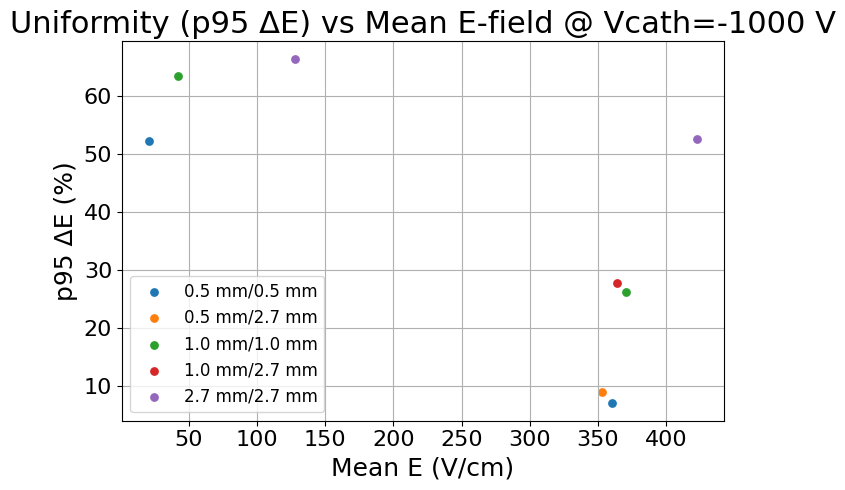

In [17]:
import matplotlib.pyplot as plt

def scatter_by_config(df, x, y, title, xlabel, ylabel):
    # builds a short 'config' label and plots each config once
    cfg = df.assign(config=(df["pitch_gate"]+"/"+df["pitch_cath"]))
    for conf, sub in cfg.groupby("config"):
        plt.scatter(sub[x], sub[y], label=conf, s=28)
    plt.grid(True); plt.legend()
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel); plt.tight_layout(); plt.show()

# Uniformity vs field (use p95 for robustness; add p90 if you want a tighter tail)
v = -1000
s = keep_only_valid_for_vcath(summary_df, v)
s = s[s["Vcath"]==v]
scatter_by_config(
    s, x="mean_Efield(V/cm)", y="p95_deltaE(%)",
    title=f"Uniformity (p95 ΔE) vs Mean E-field @ Vcath={v} V",
    xlabel="Mean E (V/cm)", ylabel="p95 ΔE (%)"
)

In [19]:
# ---- Gate=2.7 mm only: ΔE vs |E| and |Er/Ez| vs |E| (all V_cath merged) ----
def plot_gate27_vs_Efield(cath_pitch="0.5 mm"):
    frames = []
    for rec in raw_tables.values():
        meta = rec["meta"]
        if meta["pitch_gate"] != "0.5 mm" or meta["pitch_cath"] != cath_pitch:
            continue
        for Vc in pd.unique(rec["df_long"]["V_cath"]):
            sub = get_slice_for_vcath(rec, Vc)
            if sub.empty: 
                continue
            frames.append(sub[["Efield","deltaE","ratio"]])
    if not frames:
        print("No data for gate = 2.7 mm and cathode =", cath_pitch)
        return
    df = pd.concat(frames, ignore_index=True)

    # ΔE vs |E|
    plt.figure(figsize=(7,5))
    plt.scatter(df["Efield"].values, df["deltaE"].values, s=28)
    plt.xlabel("|E| (V/cm)")
    plt.ylabel("ΔE (%)")
    plt.title("Uniformity: ΔE vs |E| — gate = 2.7 mm")
    plt.grid(True); plt.tight_layout(); plt.show()

    # |Er/Ez| vs |E|
    plt.figure(figsize=(7,5))
    plt.scatter(df["Efield"].values, df["ratio"].abs().values, s=28)
    plt.xlabel("|E| (V/cm)")
    plt.ylabel("|Er/Ez|")
    plt.title("Radiality: |Er/Ez| vs |E| — gate = 2.7 mm")
    plt.grid(True); plt.tight_layout(); plt.show()

# ---- Gate=2.7 mm only: show which V_cath produced each point ----
def plot_gate27_vs_Efield_by_Vcath(vcaths=None, cath_pitch="0.5 mm", which="deltaE"):
    """
    which: 'deltaE' or 'ratio'
    Colors/markers indicate V_cath. Low and standard at -1000 V are merged by get_slice_for_vcath.
    """
    if vcaths is None:
        # choose the set that actually exists from the data
        vcaths = sorted({
            float(v) for rec in raw_tables.values()
            for v in pd.unique(rec["df_long"]["V_cath"])
        })
    markers = ["o","s","^","D","P","X","v","<",">"]
    m_for = {vc: markers[i % len(markers)] for i, vc in enumerate(vcaths)}

    plt.figure(figsize=(7,5))
    plotted_any = False

    for rec in raw_tables.values():
        meta = rec["meta"]
        if meta["pitch_gate"] != "0.5 mm" or meta["pitch_cath"] != cath_pitch:
            continue
        for Vc in vcaths:
            sub = get_slice_for_vcath(rec, Vc)
            if sub.empty:
                continue
            x = sub["Efield"].values
            if which == "deltaE":
                y = sub["deltaE"].values; ylab = "ΔE (%)"; title_what = "ΔE"
            else:
                y = sub["ratio"].abs().values; ylab = "|Er/Ez|"; title_what = "|Er/Ez|"
            plt.scatter(x, y, s=28, marker=m_for[Vc], label=f"V cath = {int(Vc)} V")
            plotted_any = True

    if not plotted_any:
        print("No data for gate = 2.7 mm and cathode =", cath_pitch)
        return

    plt.xlabel("|E| (V/cm)")
    plt.ylabel(ylab)
    plt.title(f"{title_what} vs |E| — gate = 2.7 mm (points grouped by V cath)")
    # merge legend entries with same label (multiple geometries collapse by label)
    handles, labels = plt.gca().get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    plt.legend()
    plt.grid(True); plt.tight_layout(); plt.show()

# ---- Gate=2.7 mm only: field bias E_sim − E_theory vs E_theory ----
import numpy as np
import matplotlib.pyplot as plt

def plot_gate27_field_bias_colored(L_cm=3.0, cath_pitch="2.7 mm", gate_pitch="2.7 mm",
                                   vcath_order=(-1000, -500, -60, 0, 60, 500, 1000)):
    """
    Field bias plot (E_sim - E_theory vs E_theory) for gate=gate_pitch, cathode=cath_pitch.
    Points are colored by V_cath branch. Uses get_slice_for_vcath() so low+standard
    at V_cath=-1000 are automatically merged and the cut V_cath < V_gate is applied.
    """
    frames = []
    for rec in raw_tables.values():
        meta = rec["meta"]
        if meta["pitch_gate"] != gate_pitch or meta["pitch_cath"] != cath_pitch:
            continue

        # merge all V_cath branches for this geometry
        for Vc in pd.unique(rec["df_long"]["V_cath"]):
            sub = get_slice_for_vcath(rec, Vc)
            if sub.empty:
                continue
            Vg    = sub["V_gate"].astype(float).values
            E_sim = sub["Efield"].astype(float).values
            E_th  = np.abs(Vg - float(Vc)) / float(L_cm)
            frames.append(pd.DataFrame({
                "E_th": E_th,
                "E_err": E_sim - E_th,
                "V_cath": float(Vc)
            }))

    if not frames:
        print(f"No data for gate={gate_pitch} and cathode={cath_pitch}.")
        return

    df = pd.concat(frames, ignore_index=True)

    # order V_cath in a human-friendly way
    uniq = list(sorted(df["V_cath"].unique(),
                       key=lambda x: vcath_order.index(x) if x in vcath_order else x))

    # discrete colors
    palette = plt.cm.tab10(np.linspace(0, 1, max(3, len(uniq))))
    color_map = {vc: palette[i % len(palette)] for i, vc in enumerate(uniq)}

    plt.figure()
    plt.axhline(0, ls="--", lw=1)
    for vc in uniq:
        sub = df[df["V_cath"] == vc]
        plt.scatter(sub["E_th"], sub["E_err"], s=28, c=[color_map[vc]],
                    label=f"V cath = {int(vc)} V")

    plt.xlabel("Theoretical E = |V gate − V cath| / L (V/cm)")
    plt.ylabel("E_sim − E_theory (V/cm)")
    plt.title(f"Field bias — gate = {gate_pitch}, cathode = {cath_pitch}, L = {L_cm} cm")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---- pXX-by-geometry at fixed V_cath (combines low+standard via get_slice_for_vcath) ----
def compute_pXX_by_geometry(target_vcath, percentile=95, emax=None):
    rows = []
    for rec in raw_tables.values():
        meta = rec["meta"]
        sub = get_slice_for_vcath(rec, target_vcath)
        if sub.empty:
            continue
        d = sub.dropna(subset=["deltaE","ratio","Efield"])
        if emax is not None:
            d = d[d["Efield"] <= emax]
            if d.empty:
                continue
        rows.append({
            "pitch_gate": meta["pitch_gate"],
            "pitch_cath": meta["pitch_cath"],
            "Vcath": target_vcath,
            f"p{percentile}_deltaE(%)": float(np.percentile(d["deltaE"].values, percentile)),
            "p95|Er/Ez|": float(np.percentile(np.abs(d["ratio"].values), 95)),
            "mean_Efield(V/cm)": float(d["Efield"].mean()),
        })
    df = pd.DataFrame(rows).drop_duplicates(subset=["pitch_gate","pitch_cath","Vcath"])
    if df.empty:
        return df
    return df.sort_values([f"p{percentile}_deltaE(%)","p95|Er/Ez|"])

def plot_pXX_vs_meanE(target_vcath, percentile=95, emax=None):
    df = compute_pXX_by_geometry(target_vcath, percentile=percentile, emax=emax)
    if df.empty:
        print(f"No data for V cath = {target_vcath}")
        return
    plt.figure(figsize=(7,5))
    for _, r in df.iterrows():
        label = f"{r['pitch_gate']} / {r['pitch_cath']}"
        plt.scatter(r["mean_Efield(V/cm)"], r[f"p{percentile}_deltaE(%)"], s=60, label=label)
    plt.title(f"Uniformity (p{percentile} ΔE) vs mean |E| — V cath = {target_vcath} V")
    plt.xlabel("Mean |E| (V/cm)")
    plt.ylabel(f"p{percentile} ΔE (%)")
    # de-duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    plt.legend()
    plt.grid(True); plt.tight_layout(); plt.show()

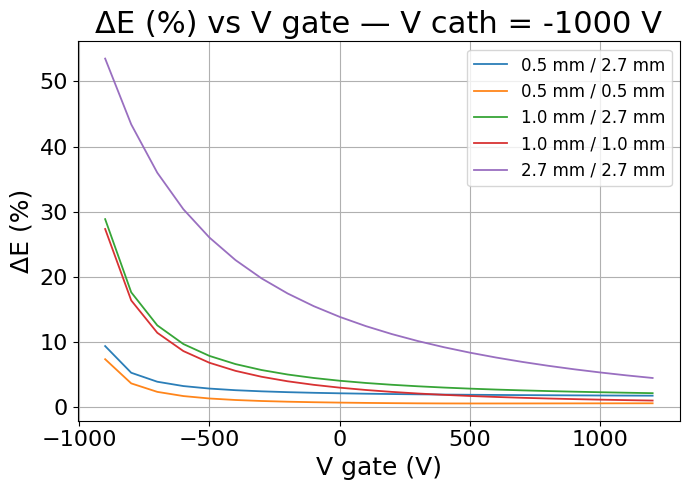

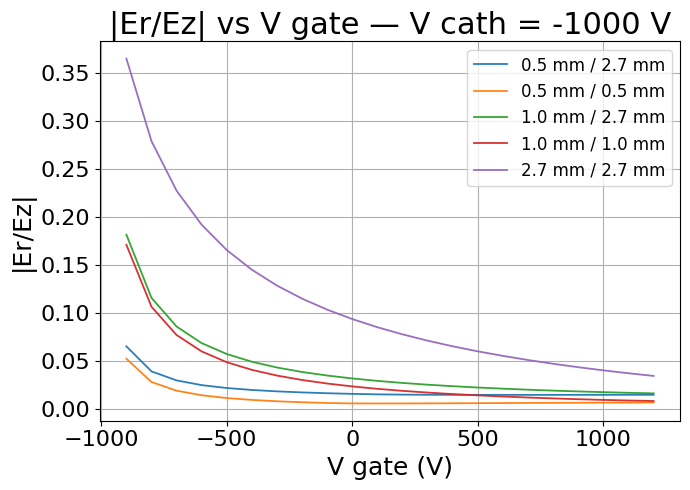

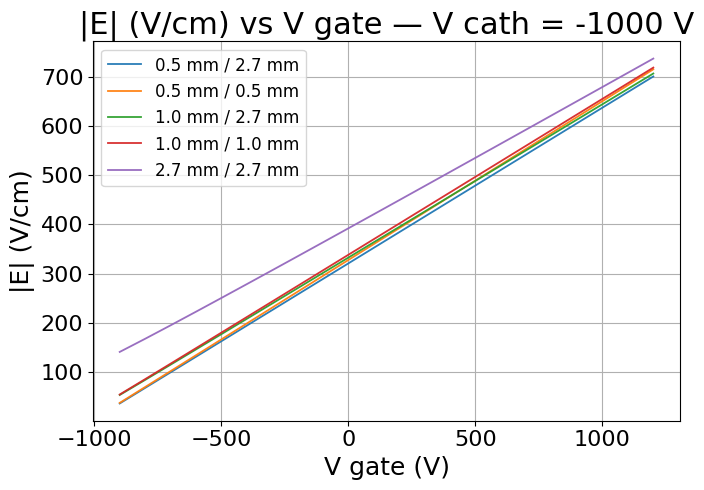

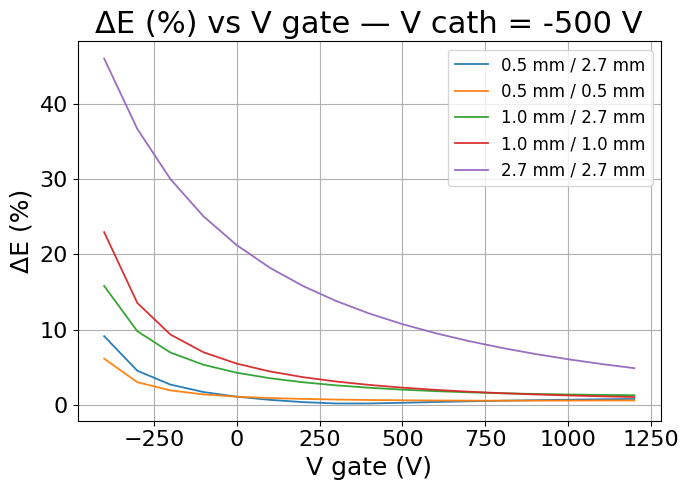

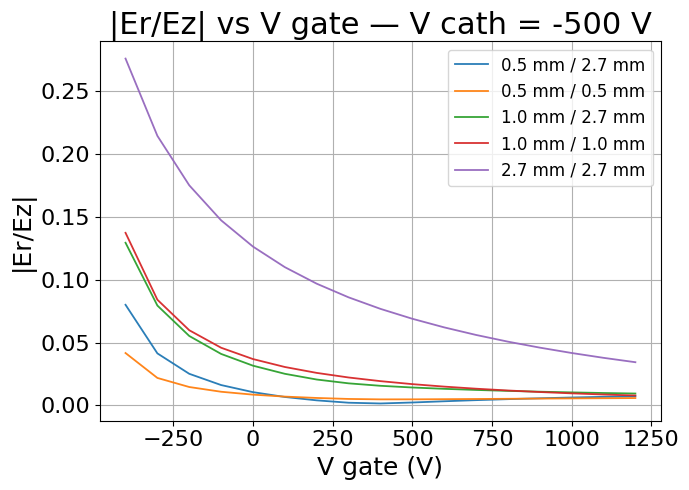

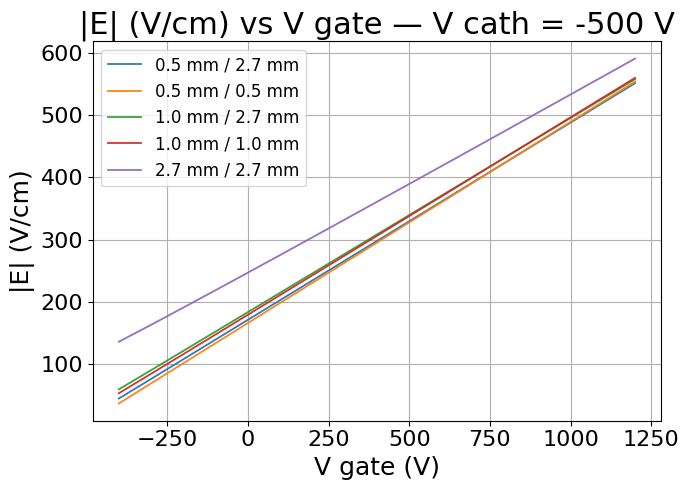

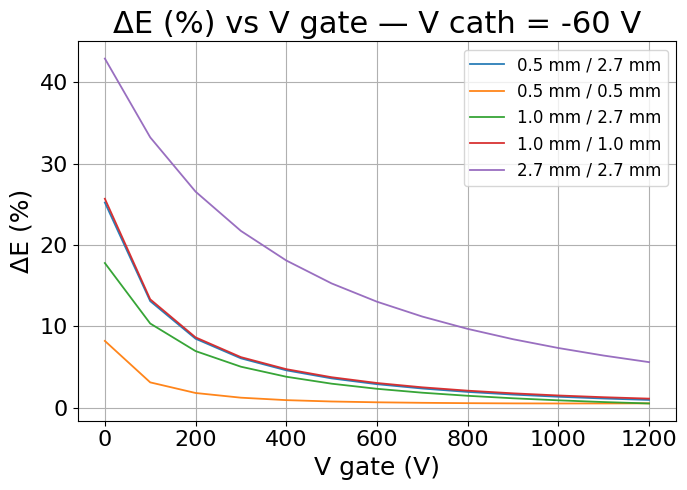

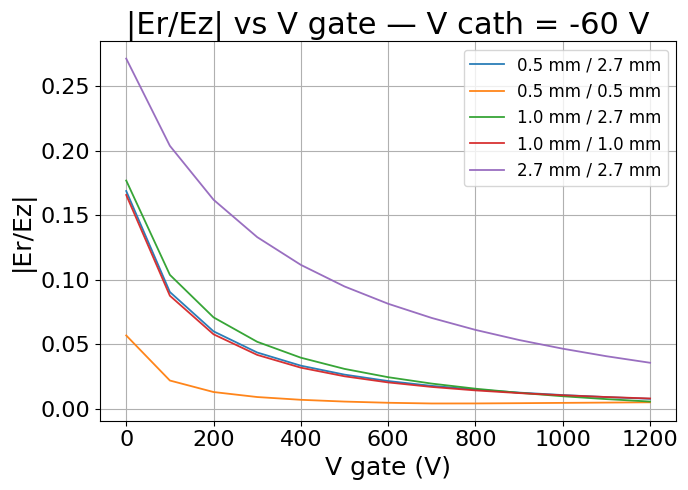

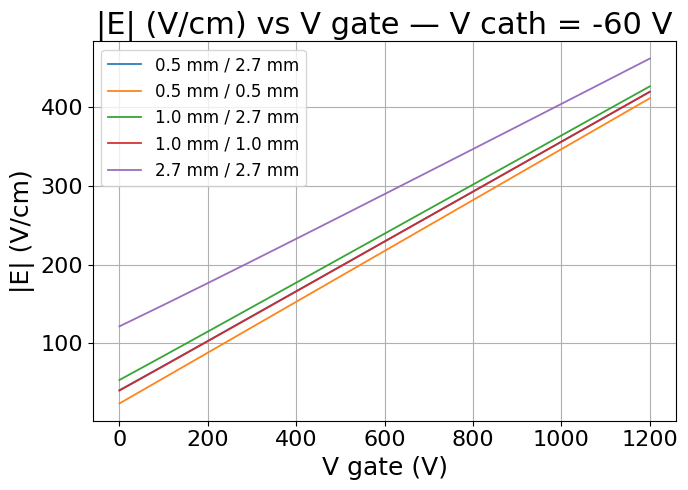

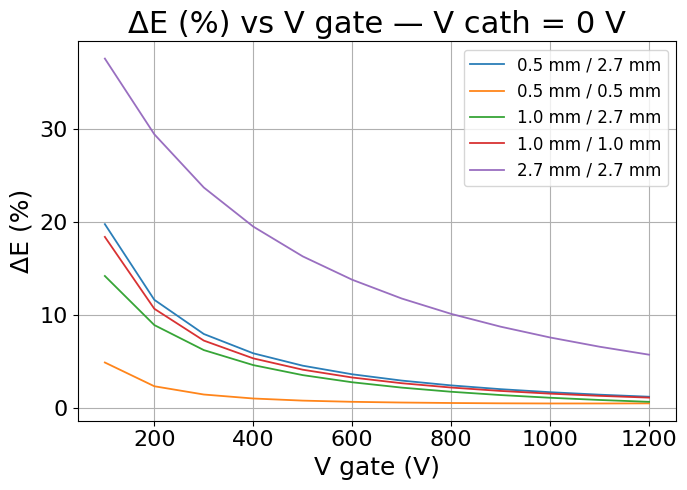

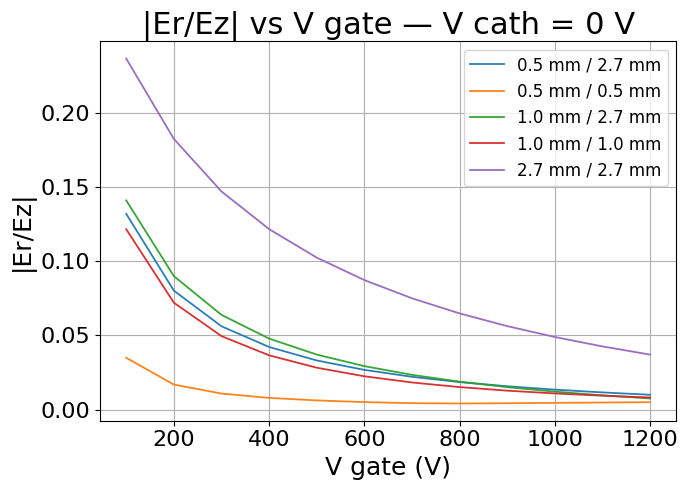

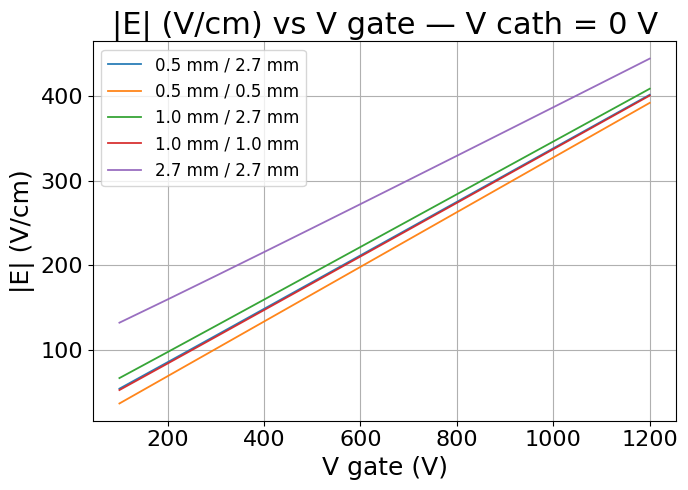

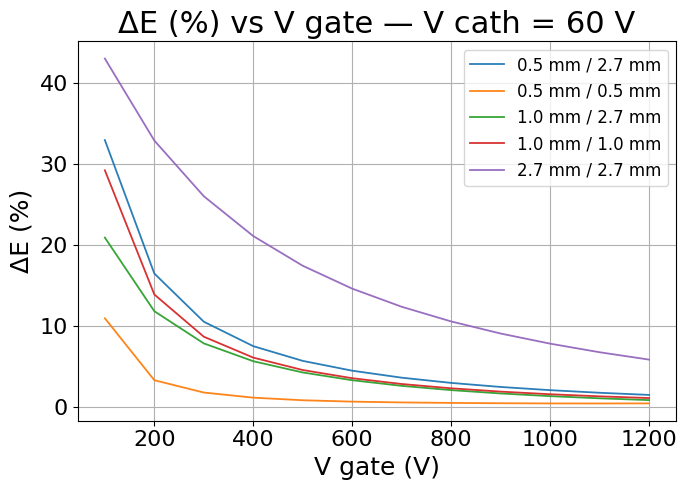

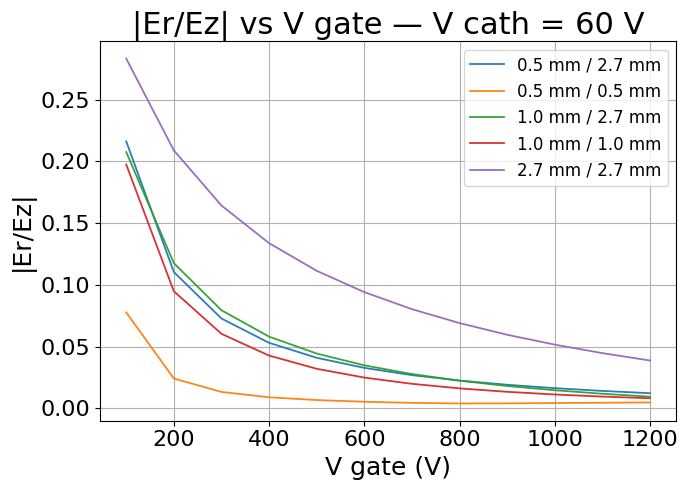

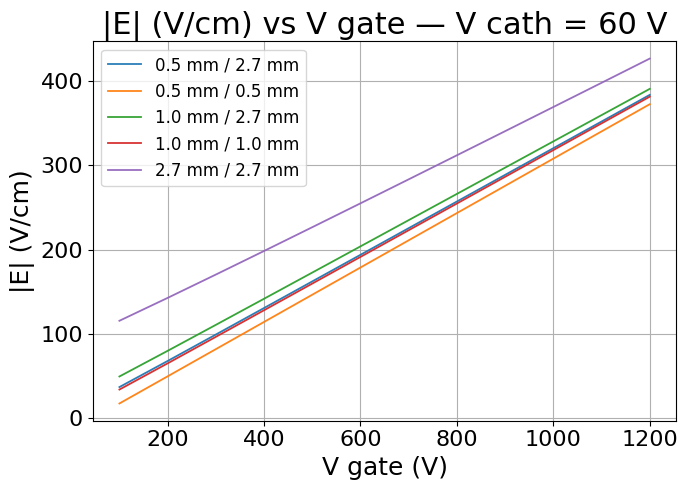

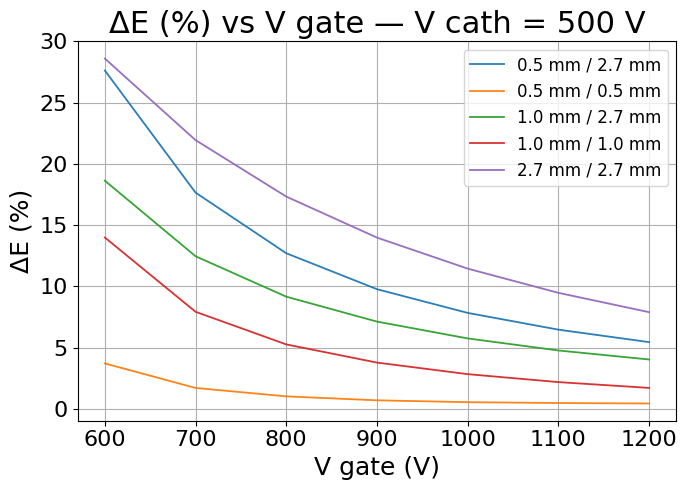

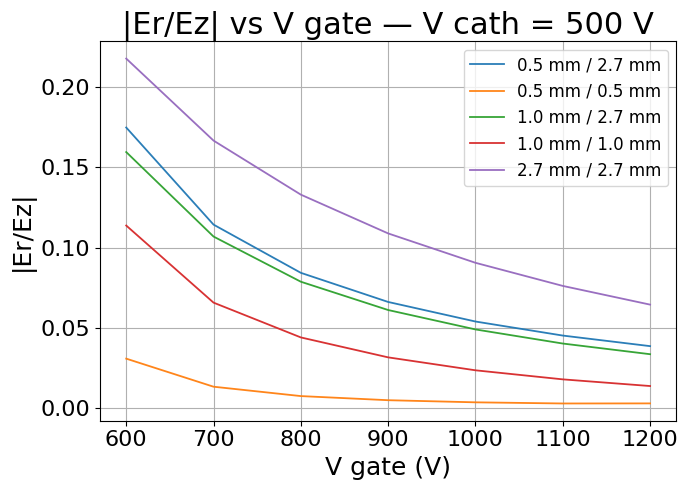

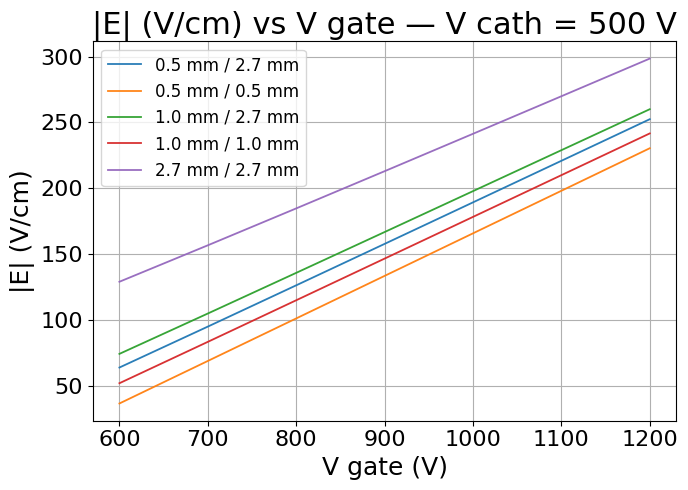

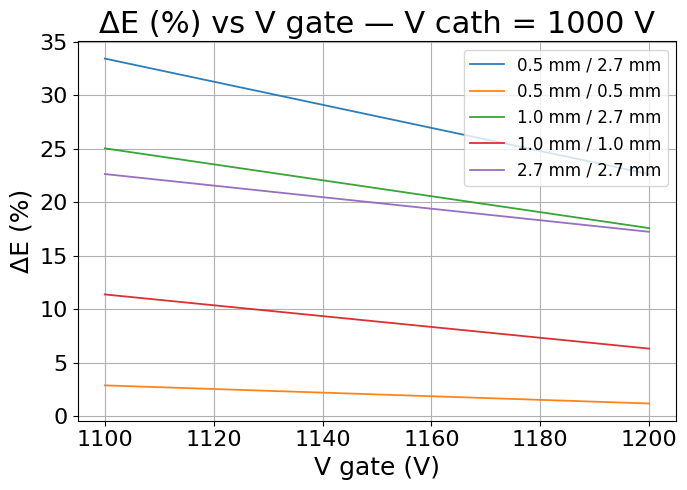

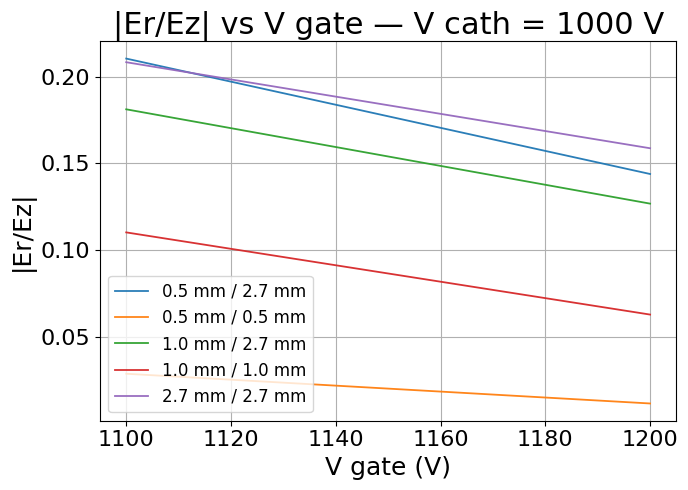

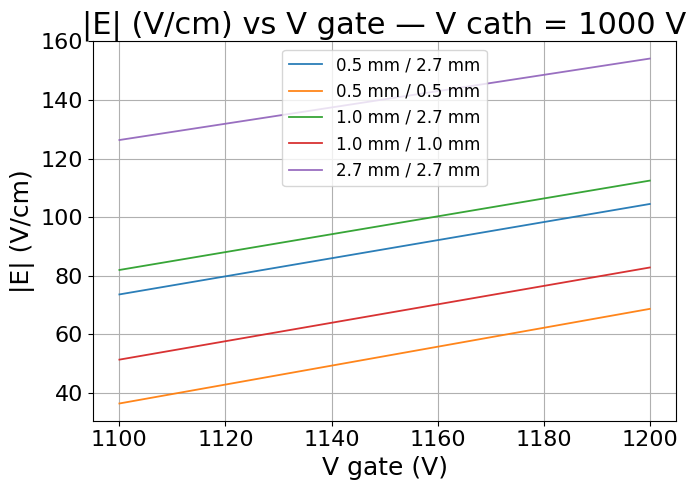

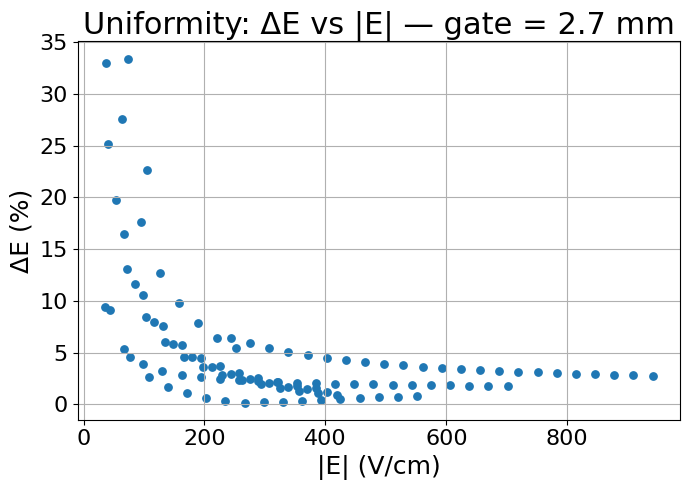

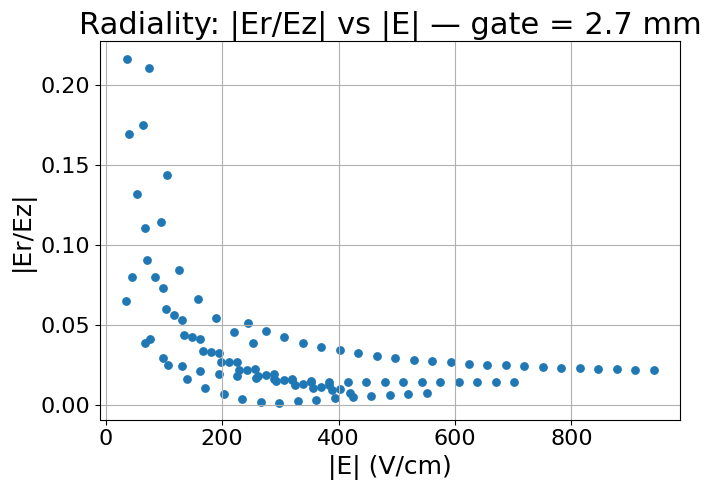

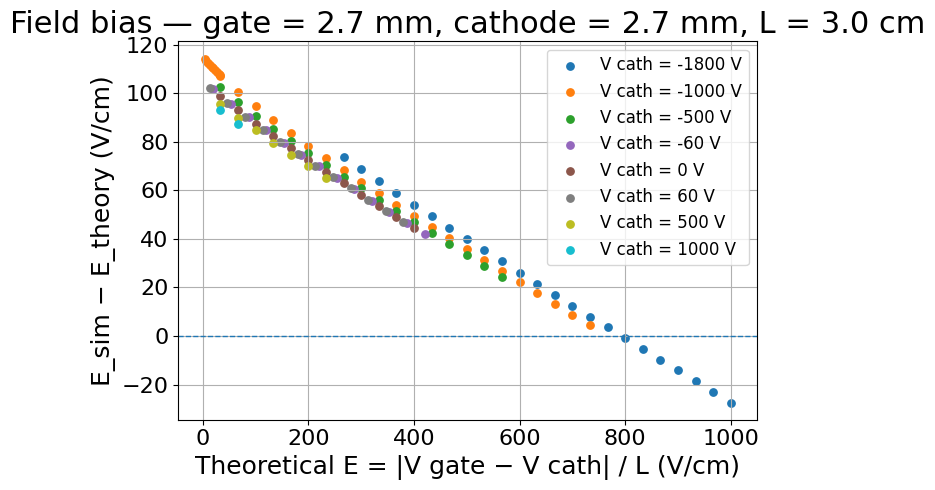

In [21]:
# === Master "figure set" cell: run the full analysis plots ===

# Adjust if needed
DRIFT_LENGTH_CM = 3.0
V_LIST = [-1000, -500, -60, 0, 60, 500, 1000]   # Only branches present in your data will render

# A) Overlays vs V_gate at fixed V_cath (ΔE, |Er/Ez|, and |E|)
for Vc in V_LIST:
    plot_overlay_vs_Vgate(Vc, y="deltaE")
    plot_overlay_vs_Vgate(Vc, y="ratio")
    plot_overlay_vs_Vgate(Vc, y="Efield")

# B) Baseline geometry (gate = 2.7 mm, cathode = 2.7 mm): ΔE and |Er/Ez| vs |E|
plot_gate27_vs_Efield(cath_pitch="2.7 mm")

# C) Baseline geometry: colored field-bias (E_sim − E_theory vs E_theory), points colored by V_cath
plot_gate27_field_bias_colored(
    L_cm=DRIFT_LENGTH_CM,
    cath_pitch="2.7 mm",
    gate_pitch="2.7 mm",
    vcath_order=(-1000, -500, -60, 0, 60, 500, 1000)
)